# Homework Assignment: Texture Recognition with ConvNets
# Introduction
In this exercise, you should design and train a convolutional neural network to classify the pixels of an image into the 47 classes of the describable texture dataset (dtd).

# [Data Preparation](https://colab.research.google.com/drive/18XgcJehCK8L0SxLohliH0uB4XVP3Ecd7#scrollTo=DrvyJv4G3-uA)

- The tools in the file dtd_loaded.py will help you to prepare the data set. (see the exercise for week 09). 
- First of all the data set is split threeways into a train, validation and test data set, the split is the same as used in some publications that also use the data set, so we will be able to compare the results with other approaches.

- For each data set 
 - we want to organise the images and labels into files, so that the all the image files have the same size and the labels are also contained in files. For that we extract the center region of each original image, convert it to grayscale and save it in a new image file that is numbered consecutively. We also construct an additional image file for the pixelwise labels.

# ConvNet Approaches
The task is to implement two different fully convolutional neural networks and train and validate them on the data. For the first network a relatively simple FCN should be used that only uses convolutional layers of stride 1, but no downsampling of the data. The second network should use a some form of downsampling and upsampling.

Use the train and validation data sets to tune your hyper parameters. This includes changing the number of layers or the sizes of the convolutional filters in the network.

Finally run the networks on the test data set to compare the performance

# Tips
While you can try to train the network in a python notebook, you could also consider to run it as a standalone program.

In both cases, you might want to use tensorboard for visualisation (will be quickly explained further in lesson 10)

Start with a small network and see if it converges and then enlarge it by adding more layers etc.

Test the network first with the example data sets from exercise 9

# FCNs for semantic segmentation

In this exercise we will look at the basics how to build a fully convolutional network for semantic segmentation.

## A first example

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive/')


In [3]:
#cd gdrive/"My Drive"/CompVIS_homework

In [1]:
# install all needed packages
from typing import Tuple
import numpy as np
import skimage.io
import tensorflow.keras as keras
from keras.utils import to_categorical
from keras import regularizers
from keras.activations import softmax
from keras.layers import Conv2D, MaxPooling2D

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
#mpl.rcParams['figure.dpi']= 400

import os 

In [1]:
# check tensorflow installation to see if we have GPU support
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4209249240739482604
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17671433509072552222
physical_device_desc: "device: XLA_CPU device"
]


In [3]:
from dtd_loader import *
download_and_convert()

Directories dtd_train, dtd_val and dtd_test already exist at target location
Remove the directories to download the data again


### Load real data
Batch of data
Training is usually done using a batch of data. For semantic segmentation, that will be a batch of image (patches).

# DATA PREPARATION

In [4]:
def prepare_data(num_images:int, foldertype:str):#
    nr_of_labels = 47
    if foldertype not in ['train','test','val']: #
        print('foldertype invalid!')#
        return None#
    else:
        image_labels = []#
        dtd_images = []#
        for i in range(num_images):  # number of considered images
            im = skimage.io.imread('dtd_'+foldertype+'/image_' + ('%05d' % i) + '.png') # load image
            im = im.reshape(1, im.shape[0], im.shape[1], 1) # reshape image
            lab = skimage.io.imread('dtd_'+foldertype+'/label_' + ('%05d' % i) + '.png') # load label
            class_id = lab[0,0]
            nr_of_pixels = (im.shape[1]-6)*(im.shape[2]-6)

            label = np.concatenate([to_categorical(class_id, nr_of_labels).reshape(1, 1, nr_of_labels)
                                    for _ in range(nr_of_pixels)], axis=1)
            image_labels.append(label)
            dtd_images.append(im.astype(np.float32) / 255.0)

        labels = np.concatenate([label for label in image_labels], axis=0)
        images = np.concatenate([im for im in dtd_images], axis=0)

        return images, labels



In [5]:
cwd = os.getcwd() # get current working directory 
os.listdir(cwd)

['C:\\Users\\steven.walker\\Desktop\\validation_data_500-batch_images.npy',
 'dtd_test',
 '.DS_Store',
 'Benny_assignment2.ipynb',
 'GHOSHAL_COMPVIS_EX_2.ipynb',
 'my_test_data_100-batch_images.npy',
 'dtd_train',
 'Pari_v2_3.ipynb',
 'my_val_data_100-batch_images.npy',
 '__pycache__',
 'David Solution.ipynb',
 'C:\\Users\\steven.walker\\Desktop\\training_data_15-batch_images.npy',
 'dtd_loader.py',
 '09-FCN for Semantic Segmentation.ipynb',
 'C:\\Users\\steven.walker\\Desktop\\training_data_15-batch_labels.npy',
 'dtd_val',
 'C:\\Users\\steven.walker\\Desktop\\training_data_500-batch_images.npy',
 'my_train_data_100-batch_images.npy',
 '.ipynb_checkpoints',
 'Pari_v2_6_good_version.ipynb']

In [9]:
def save_data_chunks(batch_size):
  data_types = ['test','train','val']
  #batch_size = 250
  for data_type in data_types:
      print('Currently preparing', data_type, 'data with batch size',batch_size)
      image_batch, label_batch = prepare_data(batch_size,'train') #set batch size, type of data to train
      path_images = cwd+'/my_'+data_type+'_data_'+ str(batch_size) +'-batch_images.npy'
      path_labels = cwd+'/my_'+data_type+'_data_'+ str(batch_size) +'-batch_labels.npy'
      np.save(path_images, image_batch)
      np.save(path_labels, label_batch)

      print(image_batch.shape, label_batch.shape)
      
#save_data_chunks(batch_size =100)

# View Data

sample_train_data
(3, 128, 128, 1) float32 (3, 14884, 47) float32


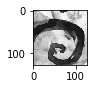

In [10]:
data_type = 'train'
print('sample_'+data_type+'_data')
im, lab = prepare_data(3,data_type)
plt.figure(figsize = (1,1))
plt.imshow(im[0].reshape(128,128), cmap='gray')
print(im.shape, im.dtype,lab.shape, lab.dtype)

sample_test_data
(3, 128, 128, 1) float32 (3, 14884, 47) float32


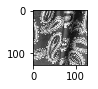

In [11]:

data_type = 'test'
print('sample_'+data_type+'_data')
im, lab = prepare_data(3,data_type)
plt.figure(figsize = (1,1))
plt.imshow(im[0].reshape(128,128), cmap='gray')
print(im.shape, im.dtype,lab.shape, lab.dtype)

sample_val_data
(3, 128, 128, 1) float32 (3, 14884, 47) float32


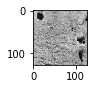

In [12]:
data_type = 'val'
print('sample_'+data_type+'_data')
im, lab = prepare_data(3,data_type)
plt.figure(figsize = (1,1))
plt.imshow(im[0].reshape(128,128), cmap='gray')
print(im.shape, im.dtype,lab.shape, lab.dtype)

##  Define FCN (Fully Convolution Network)

We will create a simple fully convolutional neural network for processing a batch of image patches

In [13]:
def fcn_no_border(input_height:int, input_width:int) -> keras.Model:
    """
    Create a simple fcn model for semantic segmentation with 47 classes
    
    based on fcn_simple_no_border  from  the notebook 09-FCN for Semantic Segmentation-ML
    """
    nr_of_labels = 47
    model = keras.Sequential()
    
    
    # (used to define input shape on the first layers)
    model.add(keras.layers.Layer(input_shape=(input_height , input_width, 1)))
    
    # add 3 convolutional layers with 3x3 filters
    model.add(keras.layers.Convolution2D(filters=64, kernel_size=3, strides=1, padding='valid', activation='relu'))
    model.add(keras.layers.Convolution2D(filters=26, kernel_size=3, strides=1, padding='valid', activation='relu'))
    model.add(keras.layers.Convolution2D(filters=32, kernel_size=3, strides=1, padding='valid', activation='relu'))
    
    # go to logits which is the number of classes
    model.add(keras.layers.Convolution2D(filters=nr_of_labels, kernel_size=1,activation = None))
    
    # reshape so that we have a sample for each pixel
    model.add(keras.layers.Reshape(target_shape=((input_height-6) * (input_width-6), nr_of_labels)))
    
    # Softmax Activation
    model.add(keras.layers.Activation('softmax'))
    
    return model
  
      


# Load data

In [14]:
#ls

In [15]:
batch_size = 100
# train data
data_type = 'train'
image_train_data = np.load('my_'+data_type+'_data_'+str(batch_size)+'-batch_images.npy')
image_train_labels = np.load('my_'+data_type+'_data_'+str(batch_size)+'-batch_labels.npy')
image_train_data.shape,image_train_labels.shape

((100, 128, 128, 1), (100, 14884, 47))

In [16]:
# val data
data_type = 'val'
image_val_data = np.load('my_'+data_type+'_data_'+str(batch_size)+'-batch_images.npy')
image_val_labels = np.load('my_'+data_type+'_data_'+str(batch_size)+'-batch_labels.npy')
image_val_data.shape,image_val_labels.shape

((100, 128, 128, 1), (100, 14884, 47))

In [17]:
# test data
data_type = 'test'

image_test_data = np.load('my_'+data_type+'_data_'+str(batch_size)+'-batch_images.npy')
image_test_labels = np.load('my_'+data_type+'_data_'+str(batch_size)+'-batch_labels.npy')
image_test_data.shape,image_test_labels.shape

((100, 128, 128, 1), (100, 14884, 47))

## Training with generators

Reading the whole data set into memory is not always possible. There are different possibilities to that problem, one is to use the Dataset classes in the tensorflow backend. We will look at that a bit more in the next lecture. The other possibility is to use *generators* from python. A generator function to use for keras will generate a batch of data at the time. 

In [18]:
# code from 09-FCN for Semantic Segmentation-ML
def batch_generator(batch_size, height: int, width: int):
    while True:
        yield image_train_data, image_train_labels

In order to use the generator, we use the ```model.fit_generator``` function. 

In [19]:
# code from 09-FCN for Semantic Segmentation-ML
PATCH_HEIGHT = 128
PATCH_WIDTH = 128
BATCH_SIZE = 50
EPOCHS = 2  ## very low
STEPS_PER_EPOCHS = 2  ### very low
model = fcn_no_border(PATCH_HEIGHT, PATCH_WIDTH)
model.summary()


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer (Layer)                (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 26)      15002     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 122, 122, 32)      7520      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 122, 122, 47)      1551      
_________________________________________________________________
reshape (Reshape)            (None, 14884, 47)         0         
_________________________________________________________________
acti

In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy','accuracy'])
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit_generator(
        generator=batch_generator( BATCH_SIZE, PATCH_HEIGHT, PATCH_WIDTH),
        epochs=EPOCHS,
        verbose=1,
        steps_per_epoch=STEPS_PER_EPOCHS,
        shuffle=False,
        callbacks=None,
    validation_data=(image_val_data, image_val_labels)
)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/2
2/2 [==============================] - 31s 15s/step - loss: 3.8482 - categorical_accuracy: 0.0144 - acc: 0.0144 - val_loss: 3.8438 - val_categorical_accuracy: 0.0299 - val_acc: 0.0299
Epoch 2/2
2/2 [==============================] - 28s 14s/step - loss: 3.8424 - categorical_accuracy: 0.0299 - acc: 0.0299 - val_loss: 3.8378 - val_categorical_accuracy: 0.0300 - val_acc: 0.0300


## Plot training

In [21]:
history.params

{'batch_size': None,
 'epochs': 2,
 'steps': 2,
 'samples': 2,
 'verbose': 1,
 'do_validation': True,
 'metrics': ['loss',
  'categorical_accuracy',
  'acc',
  'val_loss',
  'val_categorical_accuracy',
  'val_acc']}

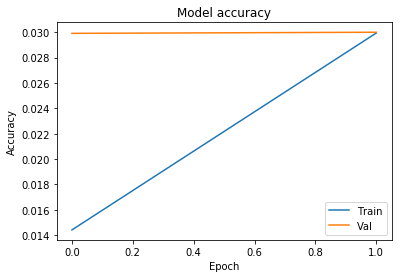

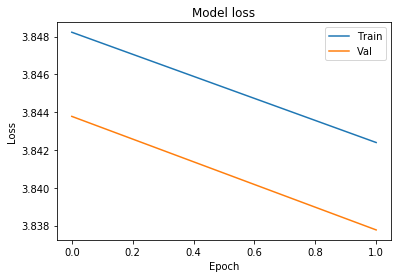

In [22]:
# Plot training accuracy values
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Val'])
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Val'])
plt.show()

## Test model

In [23]:
history.params

{'batch_size': None,
 'epochs': 2,
 'steps': 2,
 'samples': 2,
 'verbose': 1,
 'do_validation': True,
 'metrics': ['loss',
  'categorical_accuracy',
  'acc',
  'val_loss',
  'val_categorical_accuracy',
  'val_acc']}

In [24]:
evaluation = model.evaluate(image_test_data, image_test_labels,
                            batch_size=batch_size)
evaluation_metrics = dict(zip(model.metrics_names,evaluation))

print("Random approach accuracy: ", 1/47)
print("Model accuracy: ", evaluation_metrics['acc'])

100/100 [==============================] - 5s 48ms/sample - loss: 3.8378 - categorical_accuracy: 0.0300 - acc: 0.0300
Random approach accuracy:  0.02127659574468085
Model accuracy:  0.029998656


In [30]:
del model

NameError: name 'model' is not defined

In [26]:
def fcn_downsample(input_height:int, input_width:int) -> keras.Model:
    """
    Create a simple fcn model for semantic segmentation with 2 classes
    """
    nr_of_labels = 47
    model2 = keras.Sequential()
    
    
    # (used to define input shape on the first layers)
    model2.add(keras.layers.Layer(input_shape=(input_height , input_width, 1)))
    
    # add 3 convolutional layers with 3x3 filters
    model2.add(keras.layers.Convolution2D(filters=64, kernel_size=3, strides=1, padding='valid', activation='relu'))
    model2.add(keras.layers.Dropout(0.3))
    model2.add(keras.layers.Convolution2D(filters=26, kernel_size=3, strides=1,  padding='valid', activation='relu'))
    model2.add(keras.layers.Dropout(0.3))

    model2.add(keras.layers.Convolution2D(filters=32, kernel_size=3, strides=1, padding='valid', activation='relu'))
    
    # go to logits which is the number of classes
    model2.add(keras.layers.Convolution2D(filters=nr_of_labels, kernel_size=1,activation = None))
    model2.add(keras.layers.MaxPooling2D(pool_size=(4, 4), strides=1, padding='valid', data_format=None))
    
    # reshape so that we have a sample for each pixel
    model2.add(keras.layers.Reshape(target_shape=((input_height-6) * (input_width-6), nr_of_labels)))
    
    

    
    
    # Softmax Activation
    model2.add(keras.layers.Activation('softmax'))
    
    return model2

In [28]:
# code from 09-FCN for Semantic Segmentation-ML
PATCH_HEIGHT = 128
PATCH_WIDTH = 128
BATCH_SIZE = 50
EPOCHS = 2  ## very low
STEPS_PER_EPOCHS = 2  ### very low
model2 = fcn_downsample(PATCH_HEIGHT, PATCH_WIDTH)
model2.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_2 (Layer)              (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 126, 126, 64)      640       
_________________________________________________________________
dropout_2 (Dropout)          (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 124, 124, 26)      15002     
_________________________________________________________________
dropout_3 (Dropout)          (None, 124, 124, 26)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 122, 122, 32)      7520      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 122, 122, 47)      1551      
__________

In [29]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy','accuracy'])
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_down = model2.fit_generator(
        generator=batch_generator( BATCH_SIZE, PATCH_HEIGHT, PATCH_WIDTH),
        epochs=EPOCHS,
        verbose=1,
        steps_per_epoch=STEPS_PER_EPOCHS,
        shuffle=False,
        callbacks=None,
    validation_data=(image_val_data, image_val_labels)

)

Epoch 1/2


InvalidArgumentError: Input to reshape is a tensor with 66556700 values, but the requested shape has 69954800
	 [[{{node reshape_2/Reshape}}]]